<a href="https://colab.research.google.com/github/itchyfeet-patient/Going_Deeper/blob/master/ResNet_Ablation_Study/%5BGD_1%5DResNet_Ablation_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[GD_1] Project : ResNet Ablation Study**

Machine learning에서, ablation study는 
>"machine learning system의 building blocks을 제거해서 전체 성능에 미치는 효과에 대한 insight를 얻기 위한 과학적 실험"

그래서 Resnet 논문을 참고하여 Shortcut의 유무와 layer의 개수로 나뉜 Resnet34, Resnet50, Plain34, Plain50의 성능비교 실험을 하고자 합니다.

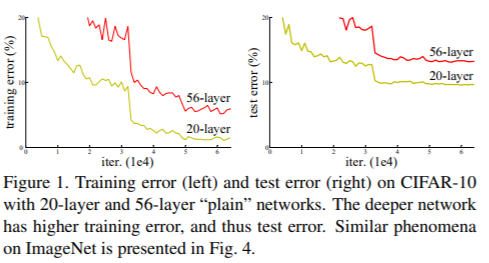

논문에서 저자들은 위 그림처럼 layer를 깊게 쌓을수록 성능이 저하되는 'Degradation Problem'을 개선하기 위해서 아이디어를 냅니다.

Degradation Problem은 신경망이 깊어지면서, 정확도가 saturated 되어 급격히 감소되는 현상을 말하고, 이는 모든 시스템이 최적화하기 쉬운것이 아니라는 것을 보여줍니다. (overfitting 때문이 아님)

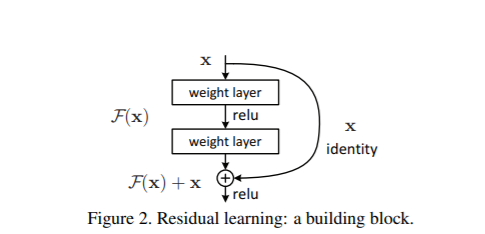

그래서 위 그림처럼 Identity Short Connection이 적용된 Residual Block을 이용, F(x) + x 에서 F(x)가 학습이 안되더라도 identity mapping x는 남을테니 성능 저하는 발생하지 않을 것이라는 아이디어입니다.

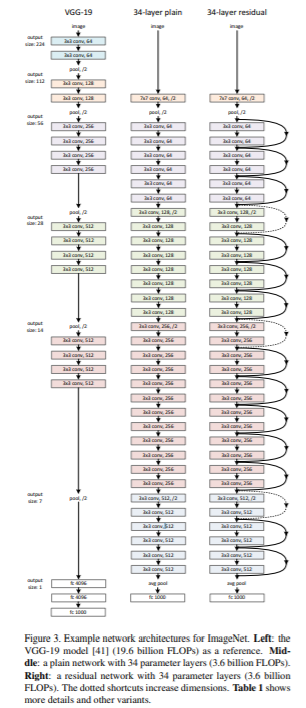

성능 비교 실험을 하기 위해  
**Plain Network** - VGG net 참고하여 만듦.  
* 모두 동일한 feature map 사이즈를 갖게 하기 위해 레이어들은 동일한 수의 filter를 가지게 함.  
* feature map 사이즈가 절반이 되면 filter 수는 2배가 되도록 만듦.
* Conv layer는 3*3의 filter, stride 2 로 downsampling, GAP를 사용, 마지막에는 softmax로 1000-way FCLayer를 통과
* 최종 레이어는 34개.    

**Residual Network** - Plain net을 기본 바탕으로 하되 Shortcut connection개념 도입.  
* Identity Shortcut은 input과 output을 같은 차원으로 맞춰줘야 함.
* 차원이 증가할 때  
    * zero padding하기
    * linear projection
    * shortcut connection = 같은 차원으로 나오는 것이야

**구현방법**  
* image resized 224 x 224
* Conv - BN - Actviation F
* Batch Size = 256 (SGD)
* Learning Rate = 0.1 (학습 정체시 /10)
* iteration 60 x $10^4$
* Weight Dacay 0.0001 (1e-4), momentum 0.9
* No Dropout


위 내용을 토대로 이제 구현해 봅시다~!

## **0) 라이브러리 버전 확인하기**

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks, backend, regularizers, initializers, models,layers, Model
import tensorflow_datasets as tfds

BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 1e-5

def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4):
    return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None

print(tf.__version__)
print(np.__version__)


2.8.2
1.21.6


## **1) ResNet 기본 블록 구성하기**

ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해봅시다!!
ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅니다.

❓ **참고**  
[논문](https://arxiv.org/pdf/1512.03385.pdf)  
[KaimingHe's Github](https://github.com/KaimingHe/deep-residual-networks)

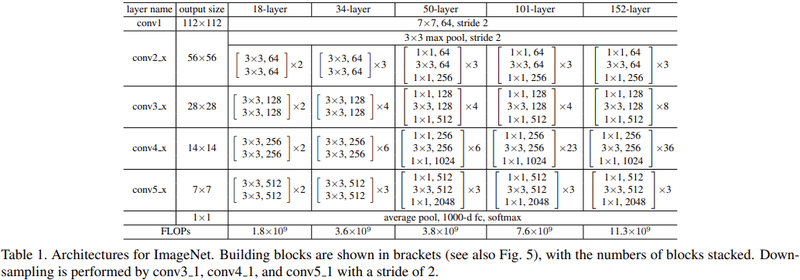

```
Q1. ResNet 논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.

-> ResNet-34와 ResNet-50 은 모두 conv block이라고 불리는 블록 구조를 3, 4, 6, 3개씩 반복해서 쌓은 구조입니다.
그러나 ResNet-50은 34와 다르게 1x1 레이어가 앞뒤로 붙습니다.
```

### **(1) Conv Block**

Plain Network, ResNet에서 계속 반복되어 사용될 Convolution Block을 함수화 해줍니다.

기본 stride는 1로 주었고 활성화함수는 모두 relu입니다. l2 regularizer를 사용하기 위해서 앞서 선언해놓은 `_gen_l2_regularizer`를 가져와줍니다.  
Batch normailization decay와 epsilon값은 논문의 implementation에 기재된 수치 그대로 사용했습니다.

논문과 동일하게 Conv - BN - Activation Function 순서대로 사용했습니다.

그리고 모든 네트워크 구성은 function api 방식을 사용했습니다.

In [9]:
def conv_block(layer, 
               channel, 
               kernel_size,
               padding='same', 
               strides=1, 
               activation='relu', 
               name='0',
               use_l2_regularizer=True               
               ):

    x = layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = layers.BatchNormalization(momentum=BATCH_NORM_DECAY,
                            epsilon=BATCH_NORM_EPSILON,
                            name=f'batch_{name}')(x)
    if activation:
        x = layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

### **(2) Plain Block**

conv block을 이용해서 Plain Newtwork에서 반복되는 부분을 함수화했습니다. block_num(블럭의 수)이 0보다 크고 num_cnn(블럭 내에 존재하는 Conv layer*2의 개수) 첫번째 Convolution layer일 경우, stride를 2로 설정해서 downsampling이 되도록 했습니다.

In [10]:
def plain_block(input_layer, 
                block_num=0, 
                num_cnn=3, 
                channel=64, 
                is_50=True,
                ):

    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_block(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_block(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_block(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x

### **(3) Plain Network**

```
assert 문 사용이유

* assert(가정 설정문)
* 뒤의 조건이 True가 아니면 AssertError를 발생함
* 뒷부분 코드가 정상적으로 실행되기 위한 input 조건을 검사하는 상황에서 주로 사용됨.  
* if ~ raise 구문으로 대체가 가능한데 왜 쓰는거에요?  
    1. 코드 앞부분에 만족해야 할 조건들을 한번에 몰아서 검사할 수 있다.
    2. 검사해야 할 조건이 여러개면, 가독성이 향상되고 디버깅이 편해질 수 있다.
    3. 코드 실행부가 길어질 경우, 조건 검사를 앞으로 따로 빼면서 2번 장점이 더해짐.  
```

[참고](https://jimmy-ai.tistory.com/170)


위 이유로 assert문을 사용해서 num_cnn_list와 channel_list의 개수가 같은지 검사했습니다. 둘이 같아야 plain block을 구성할 때 쌍으로 묶어 `plain_block`함수에 전달해줄 수 있기 때문입니다.

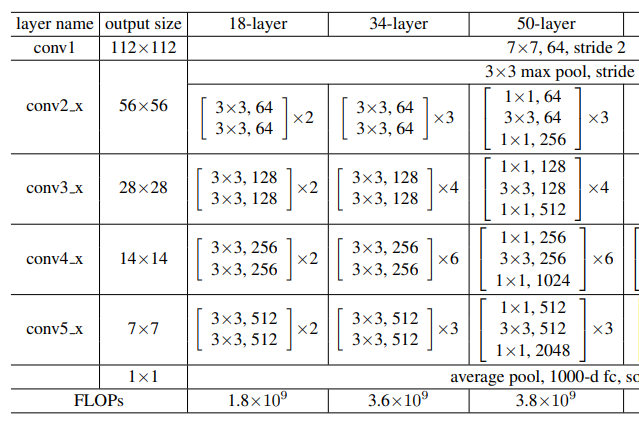

위 논문속 네트워크 구조대로 `builiding_plain_net`을 구성했습니다.   
7x7 64 stride = 2 에서부터 global average pooling까지..  
마지막 조건문은 cats vs dogs 데이터셋을 사용시 이진분류므로 sigmoid를 사용하도록 해줬습니다.

In [11]:
def build_plain_net(num_cnn_list, 
                    channel_list, 
                    is_50=True, 
                    cats_vs_dogs=False, 
                    input_shape=(32,32,3), 
                    num_classes=10, 
                    name='Plain_50',
                    use_l2_regularizer=True):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_block(input_layer, 64, (7,7), strides=2, name='first')
    plain = layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = layers.GlobalAveragePooling2D(name='GAP')(plain)
    
    if cats_vs_dogs:
        output = layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = Model(inputs=input_layer, outputs=output, name=name)
    
    return model

### **(4) ResNet 기본 블록**

resnet을 구성할 수 있도록 기본 블록을 함수화했습니다. plain block과 동일한데 shortcut의 유무가 다릅니다. 

In [12]:
def build_residual_block(input_layer, 
                         block_num=0, 
                         num_cnn=3, 
                         channel=64, 
                         is_50=True):
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_block(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_block(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_block(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            
            x = layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_block(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x

In [13]:
def build_resnet(num_cnn_list, 
                 channel_list, 
                 is_50=True, 
                 cats_vs_dogs=False, 
                 input_shape=(32,32,3), 
                 num_classes=10, 
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_block(input_layer, 64, (7,7), strides=2, name='first')
    res = layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        
    gap = layers.GlobalAveragePooling2D(name='GAP')(res)
    if cats_vs_dogs:
        output = layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = Model(inputs=input_layer, outputs=output, name=name)
    return model

### **(5) Plain-34**

논문에 나온 사진 (위 참고)을 토대로 conv layer가 반복되는 개수, 블럭을 거치면서 변경되는 채널의 개수를 리스트로 넣어줍니다.

In [14]:
plain_34 = build_plain_net(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv_first (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_first (BatchNormaliza  (None, 112, 112, 64)     256       
 tion)                                                           
                                                                 
 act_first (Activation)      (None, 112, 112, 64)      0         
                                                                 
 maxpool_first (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv_0_01 (Conv2D)          (None, 56, 56, 64)        369

### **(6) Plain-50**

In [15]:
plain_50 = build_plain_net(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv_first (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_first (BatchNormaliza  (None, 112, 112, 64)     256       
 tion)                                                           
                                                                 
 act_first (Activation)      (None, 112, 112, 64)      0         
                                                                 
 maxpool_first (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv_0_01 (Conv2D)          (None, 56, 56, 64)        416

## **2) ResNet-34, ResNet-50 Complete Model**

### **(1) ResNet-34 구조 확인**

In [16]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_first (Conv2D)            (None, 112, 112, 64  9472        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_first (BatchNormalizatio  (None, 112, 112, 64  256        ['conv_first[0][0]']             
 n)                             )                                                         

### **(2) ResNet-50 구조 확인**

In [17]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_first (Conv2D)            (None, 112, 112, 64  9472        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_first (BatchNormalizatio  (None, 112, 112, 64  256        ['conv_first[0][0]']             
 n)                             )                                                         

## **3) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34**

### **(1) Ablation Study**

 ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

#### **데이터 불러오기**

In [18]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteRYOXQS/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [19]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [20]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [21]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224)) # resize
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [22]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

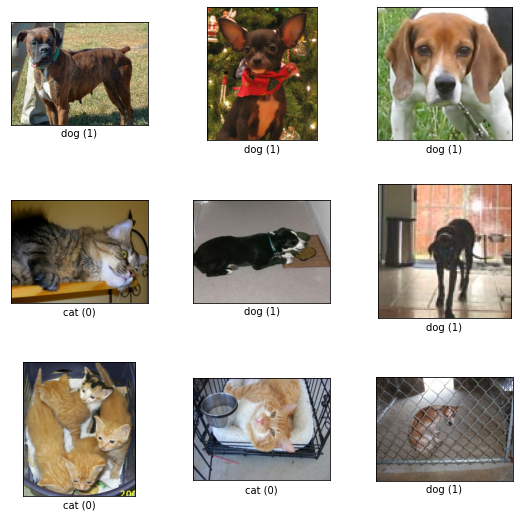

In [23]:
fig = tfds.show_examples(ds_train, ds_info)

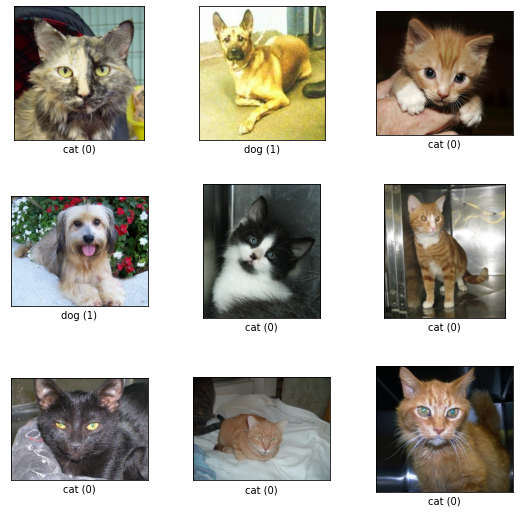

In [24]:
fig = tfds.show_examples(ds_test, ds_info)

#### **🐧 학습돌입**


In [25]:
!head -n 3 /proc/meminfo

MemTotal:       26690640 kB
MemFree:        18361420 kB
MemAvailable:   24637980 kB


논문에 적힌대로 batch size와 iteration을 줬더니 ram 사용량을 초과했다 ;; ㅠㅠ  
그러면 에포크가 6003이라 학습했어도 밤 샜을듯

In [26]:
BATCH_SIZE = 32 #256
iteration = 15000 #600000
EPOCH = iteration*BATCH_SIZE//int(ds_info.splits['train'].num_examples)

In [27]:
EPOCH

20

In [28]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [29]:
def scheduler(epoch, lr):
    if epoch == EPOCH//2:
        lr *=0.1
        print(lr)
    elif epoch == (EPOCH//4)*3:
        lr *=0.1
        print(lr)
    return lr

In [30]:
lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.1, monitor='val_loss', patience=1, verbose=2, min_lr=1e-6)
# lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

##### **⭐ resnet-34**

In [31]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3),
                         name='ResNet_34')

In [32]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


654/654 [==============================] - 157s 198ms/step - loss: 2.2761 - accuracy: 0.5753 - val_loss: 2.0281 - val_accuracy: 0.6076 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 128s 196ms/step - loss: 1.8401 - accuracy: 0.6413 - val_loss: 1.6731 - val_accuracy: 0.6762 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - ETA: 0s - loss: 1.5171 - accuracy: 0.7047
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
654/654 [==============================] - 128s 195ms/step - loss: 1.5171 - accuracy: 0.7047 - val_loss: 1.6807 - val_accuracy: 0.6038 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - 128s 195ms/step - loss: 1.3044 - accuracy: 0.7681 - val_loss: 1.2547 - val_accuracy: 0.7977 - lr: 0.0100
Epoch 5/20
654/654 [==============================] - 128s 195ms/step - loss: 1.2322 - accuracy: 0.7986 - val_loss: 1.2383 - val_accuracy: 0.7903 - lr: 0.0100
Epoch 6/20
654/654 [==============================] - 12

##### **⭐ resnet-50**

In [33]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3))

In [34]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 113s 147ms/step - loss: 5.6642 - accuracy: 0.5511 - val_loss: 4.8800 - val_accuracy: 0.6367 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 94s 144ms/step - loss: 4.3779 - accuracy: 0.6301 - val_loss: 3.8960 - val_accuracy: 0.6545 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 94s 144ms/step - loss: 3.4895 - accuracy: 0.6757 - val_loss: 3.1573 - val_accuracy: 0.6736 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - 95s 145ms/step - loss: 2.8152 - accuracy: 0.6947 - val_loss: 2.6309 - val_accuracy: 0.7083 - lr: 0.1000
Epoch 5/20
654/654 [==============================] - 94s 144ms/step - loss: 2.2694 - accuracy: 0.7402 - val_loss: 2.1107 - val_accuracy: 0.7001 - lr: 0.1000
Epoch 6/20
654/654 [==============================] - 94s 144ms/step - loss: 1.8583 - accuracy: 0.7653 - val_loss: 1.7247 - val_accuracy: 0.7396 - lr: 0.1000
Epoch 7/20
654/654 [==============================]

##### **⭐ plain-34**

In [35]:
plain_34 = build_plain_net(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3),
                       name='Plain_34')

In [36]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 134s 186ms/step - loss: 2.0940 - accuracy: 0.5253 - val_loss: 1.9016 - val_accuracy: 0.4996 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 121s 185ms/step - loss: 1.7568 - accuracy: 0.5440 - val_loss: 1.6183 - val_accuracy: 0.5530 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 121s 185ms/step - loss: 1.5052 - accuracy: 0.5686 - val_loss: 1.4024 - val_accuracy: 0.5677 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - 121s 185ms/step - loss: 1.3149 - accuracy: 0.5768 - val_loss: 1.2437 - val_accuracy: 0.5030 - lr: 0.1000
Epoch 5/20
654/654 [==============================] - 121s 186ms/step - loss: 1.1648 - accuracy: 0.5840 - val_loss: 1.0975 - val_accuracy: 0.6081 - lr: 0.1000
Epoch 6/20
654/654 [==============================] - 121s 186ms/step - loss: 1.0523 - accuracy: 0.5892 - val_loss: 1.0007 - val_accuracy: 0.6011 - lr: 0.1000
Epoch 7/20
654/654 [==========================

##### **⭐ plain-50**

In [37]:
plain_50 = build_plain_net(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3))

In [38]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 203s 287ms/step - loss: 4.8308 - accuracy: 0.5048 - val_loss: 4.2920 - val_accuracy: 0.4883 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 185s 283ms/step - loss: 3.8405 - accuracy: 0.5523 - val_loss: 3.4397 - val_accuracy: 0.5692 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 185s 283ms/step - loss: 3.1138 - accuracy: 0.5656 - val_loss: 2.8234 - val_accuracy: 0.5321 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - 186s 284ms/step - loss: 2.5679 - accuracy: 0.5162 - val_loss: 2.3407 - val_accuracy: 0.4891 - lr: 0.1000
Epoch 5/20
654/654 [==============================] - 186s 284ms/step - loss: 2.1360 - accuracy: 0.5407 - val_loss: 1.9542 - val_accuracy: 0.5586 - lr: 0.1000
Epoch 6/20
654/654 [==============================] - 185s 284ms/step - loss: 1.8032 - accuracy: 0.5535 - val_loss: 1.6686 - val_accuracy: 0.5638 - lr: 0.1000
Epoch 7/20
654/654 [==========================

#### **4.  결과비교**

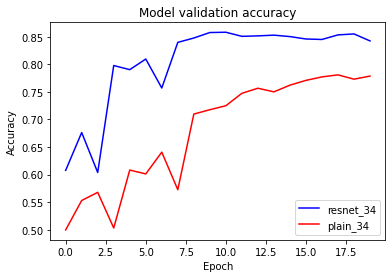

In [39]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='lower right')
plt.show()

resnet 34가 plain 34보다 성능이 좋다! 그렇다면 .. resnet 50과는 어떨까

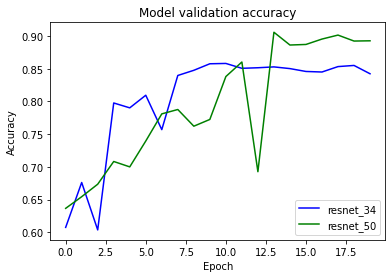

In [40]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='lower right')
plt.show()

대망의 resnet 34 vs resnet 50 !!!  
학습 초기에는 34가 성능이 좋았지만 후반부에 resnet 50이 더 좋아졌다~!

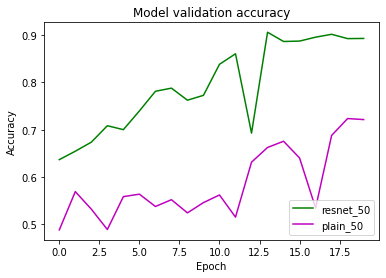

In [41]:
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='lower right')
plt.show()

resnet 50 성능이 월등하다.

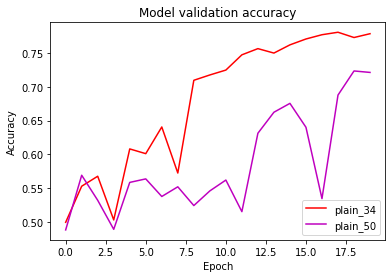

In [42]:
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'plain_50'], loc='lower right')
plt.show()

이 논문을 쓰게 된 계기가 되었던 그래프다. 예측했던 결과 그대로 나왔다. 

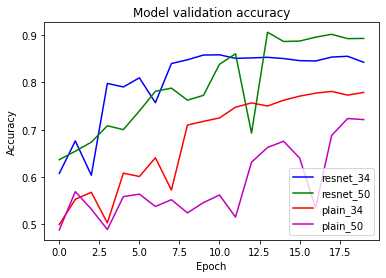

In [43]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()

resnet 50 고생했쟌아~

## **(2) 시각화**
학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

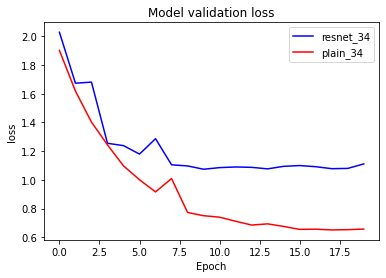

In [54]:
plt.plot(history_34.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'r')
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='best')
plt.show()

resnset34의 loss가 plain보다 더 크다. 성능은 resnet이 더 좋은뎅

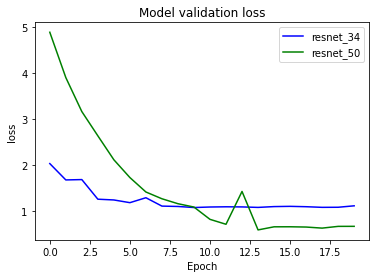

In [53]:
plt.plot(history_34.history['val_loss'], 'b')
plt.plot(history_50.history['val_loss'], 'g')
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='best')
plt.show()

resnet50은 성능도 좋고 loss도 덜하고

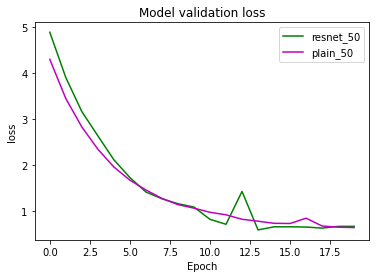

In [55]:
plt.plot(history_50.history['val_loss'], 'g')
plt.plot(history_plain_50.history['val_loss'], 'm')
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='best')
plt.show()

loss는 두 모델이 비슷하게 낮은 수준이다.

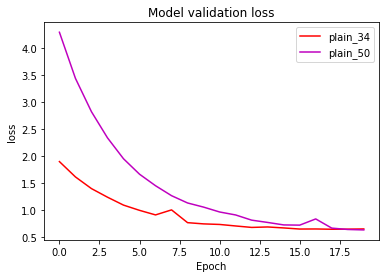

In [56]:
plt.plot(history_plain_34.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'm')
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'plain_50'], loc='best')
plt.show()

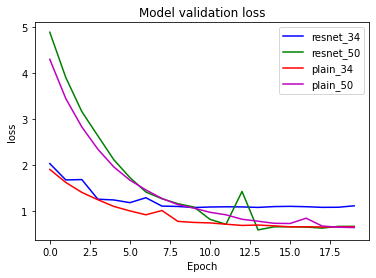

In [57]:
plt.plot(history_34.history['val_loss'], 'b')
plt.plot(history_50.history['val_loss'], 'g')
plt.plot(history_plain_34.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'm')
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='best')
plt.show()

## **(3) 추가 실험**
시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다.

[Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)

## **💲 루브릭**

| **평가문항** | **상세기준** | **성취결과** |
|:---:|---|:---:|
| 1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가? | 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다. | O |
| 2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? | tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다. | O |
| 3. Ablation Study 결과가 바른 포맷으로 제출되었는가? | ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다. | O |

## ✍ **회고**

* 역대급으로 막막한 과제였다. 그래서 우수 고잉디퍼를 많이 참고했다. (ㅎㅎ) 그러나 논문과 구조를 잘 이해하고자 노력했다.
* 그래서 마지막날에 제출했당.
* 말과 휴먼 데이터셋에도 적용해보고 싶었는데 .. 이따 시간되면 해봐야겠다.
* 고잉디퍼 쉽지않다..
* 이해를 완벽히 하고 넘어가려니, 그리고 프로젝트를 구상하려니.. 쉽지 않았다.
* 처음에는 막무가내로 프로젝트를 돌입했는데 하나도 모르겠더라..  
나중엔 막히는 부분에서 이것저것 찾아보다가 다시 처음부터 논문이랑 논문리뷰 열심히 읽고 구조 어떻게 할지 메모장에 띄워놓고 코드랑 같이 보니까 훨씬 갈피가 잡혔다.
* 중간중간에 오류가 생겨서 검색했는데 구글에서 안나오는 오류들이 많았다. 보통은 지적당한 부분말고 다른부분을 고치니까 해결되곤 했다... 흑

### 📚 **참고문헌**

[resnet 구현](https://git.dst.etit.tu-chemnitz.de/external/tf-models/-/blob/1d057dfc32f515a63ab1e23fd72052ab2a954952/official/vision/image_classification/resnet_model.py)  
[resnet 구현 2](https://github.com/JaeHeee/AIFFEL_Project/blob/master/Going_Deeper/ResNet.ipynb)  
[resnet 논문리뷰](https://jxnjxn.tistory.com/22)